## ДЗ_5

- Попробуйте изменить параметры нейронной сети, работающей с датасетом imdb, либо нейронной сети, работающей airline-passengers (она прилагается вместе с датасетом к уроку в виде отдельного скрипта) так, чтобы улучшить её точность. Приложите анализ
- Попробуйте изменить параметры нейронной сети, генерирующей текст таким образом, чтобы добиться генерации как можно более осмысленного текста. Пришлите лучший текст из получившихся и опишите предпринятые для его получения действия. Можно использовать текст другого произведения
- *Попробуйте реализовать нейронную сеть архитектуры LSTM на numpy
- *Предложите свои варианты решения проблемы исчезающего градиента в RNN

In [53]:
# Рисовать графики сразу же
%matplotlib inline

import os
import datetime

import pandas as pd
# import tensorflow as tf
import matplotlib.pyplot as plt
# from tensorflow.keras import utils
# import numpy as np
import tensorflow.keras as keras
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential #, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

# # from google.colab import files
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [54]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [55]:
# files.upload()
# !ls

In [56]:
df = pd.read_csv('airline-passengers.csv')
df.rename(columns={'Month': 'Date'}, inplace=True)
df.set_index('Date', inplace=True)
df.shape

(144, 1)

In [57]:
df.index = pd.to_datetime(df.index, format='%Y-%m')
df.sort_index(ascending=True, inplace=True)
df.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


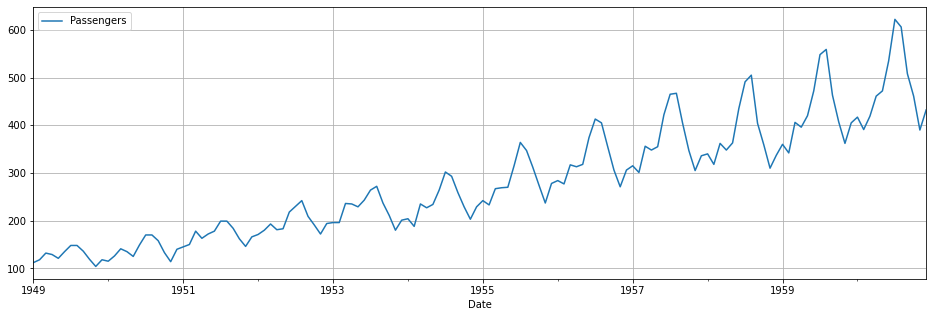

In [58]:
df.plot(figsize = (16,5))
plt.grid('On')
plt.show()

Добавим дату как признаки: как "месяц в году"/12 и (год-1949)

In [59]:
df['month'] = pd.to_datetime(df.index).month / 12
df['year'] = pd.to_datetime(df.index).year - 1949
df.tail()

,Passengers,month,year
Date,,,
1960-08-01,606,0.666667,11
1960-09-01,508,0.750000,11
1960-10-01,461,0.833333,11
1960-11-01,390,0.916667,11
1960-12-01,432,1.000000,11


In [60]:
data = df.copy() # берем все что есть

In [61]:
data = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)
data.head()

,Passengers,month,year
0,0.015444,0.000000,0.0
1,0.027027,0.090909,0.0
2,0.054054,0.181818,0.0
3,0.048263,0.272727,0.0
4,0.032819,0.363636,0.0


In [62]:
# def normalize(data, data_mean=0, data_std=0):
    
#     if data_std == 0:
#         data_mean = data.mean(axis = 0)
#         data_std = data.std(axis = 0)
        
#     return (data - data_mean) / data_std, data_mean, data_std

In [63]:
train_split = 91

# _,d_m,d_s =  normalize(data.iloc[:train_split, 0].values)
# data.iloc[:, 0] = (data.iloc[:, 0].values - d_m) / d_s

In [64]:
# список признаков, по которым будем учить
channelIndexes = [0, 1, 2]

# длина теста
valLen = data.shape[0] - train_split
# длина истории для работы
xLen = 6
# отступ тестов от тренировок
bias = 5

# вычисляем точку разделения ряда на тесты и тренировку

# делим
train_data = data.iloc[0:train_split, channelIndexes]
val_data = data.iloc[train_split+bias:, channelIndexes]

In [65]:
train_data.shape, val_data.shape

((91, 3), (48, 3))

In [66]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h = future

# параметры модели для обучения
learning_rate = 0.001
batch_size = 32
epochs = 100

Chanel_numb = len(channelIndexes)

start = xLen + future
end = start + train_split-1

xTrain_df = train_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xTrain = xTrain_df[[train_data.columns[i] for i in range(Chanel_numb)]].values
yTrain = train_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future 

label_start = len(train_data)+bias+xLen + future +1

xVal_df = val_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xVal = xVal_df[[val_data.columns[i] for i in range(Chanel_numb)]].values
yVal = val_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

In [67]:
print(xTrain.shape)

print(yTrain.shape)


print(xVal.shape)

print(yVal.shape)

(85, 3)
(85,)
(42, 3)
(42,)


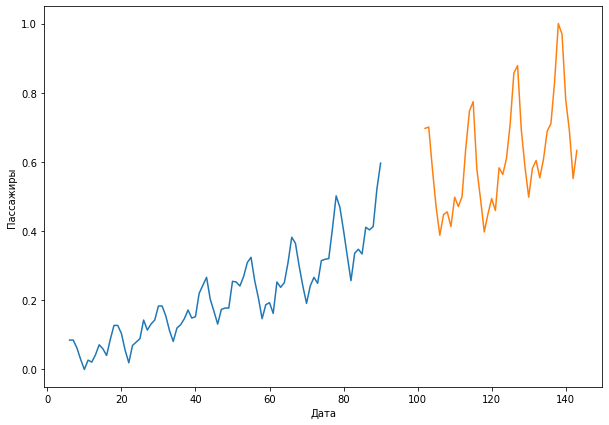

In [68]:
plt.figure(figsize = (10, 7))
plt.plot(data.index[xLen:yTrain.shape[0]+xLen], yTrain[:])
plt.plot(data.index[yTrain.shape[0]+bias+future+2*xLen-1:], yVal[:])
# plt.grid()
plt.xlabel('Дата')
plt.ylabel('Пассажиры')

plt.show()

In [69]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length = xLen,
    sampling_rate = 1,
    batch_size = batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length = xLen,
    sampling_rate = 1,
    batch_size = batch_size,
)

In [70]:
for batch in dataset_val.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (5, 6, 3)
Target shape: (5,)


In [71]:
inputs[1,0,:]

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.58494208, 0.81818182, 0.90909091])>

In [72]:
inputs[1,:,0]

<tf.Tensor: shape=(6,), dtype=float64, numpy=
array([0.58494208, 0.4980695 , 0.58108108, 0.6042471 , 0.55405405,
       0.60810811])>

In [73]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=0.6081081081081081>

In [74]:
for batch in dataset_train.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 6, 3)
Target shape: (32,)


In [75]:
inputs[0,:,0]

<tf.Tensor: shape=(6,), dtype=float64, numpy=
array([0.15444015, 0.11196911, 0.08108108, 0.11969112, 0.12934363,
       0.14671815])>

In [76]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=0.17181467181467183>

In [77]:
logdir = os.path.join("logs2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard( logdir, histogram_freq=1)

Epoch 1/100
3/3 [==============================] - 3s 293ms/step - loss: 0.0316 - mae: 0.1545 - val_loss: 0.1963 - val_mae: 0.4079
Epoch 2/100
3/3 [==============================] - 0s 59ms/step - loss: 0.0105 - mae: 0.0805 - val_loss: 0.0888 - val_mae: 0.2369
Epoch 3/100
3/3 [==============================] - 0s 59ms/step - loss: 0.0185 - mae: 0.1161 - val_loss: 0.0752 - val_mae: 0.2171
Epoch 4/100
3/3 [==============================] - 0s 59ms/step - loss: 0.0127 - mae: 0.0934 - val_loss: 0.0895 - val_mae: 0.2584
Epoch 5/100
3/3 [==============================] - 0s 63ms/step - loss: 0.0077 - mae: 0.0697 - val_loss: 0.0881 - val_mae: 0.2624
Epoch 6/100
3/3 [==============================] - 0s 60ms/step - loss: 0.0053 - mae: 0.0552 - val_loss: 0.0591 - val_mae: 0.2048
Epoch 7/100
3/3 [==============================] - 0s 64ms/step - loss: 0.0029 - mae: 0.0420 - val_loss: 0.0273 - val_mae: 0.1250
Epoch 8/100
3/3 [==============================] - 0s 66ms/step - loss: 0.0031 - mae: 0.0

3/3 [==============================] - 0s 64ms/step - loss: 8.8963e-04 - mae: 0.0233 - val_loss: 0.0038 - val_mae: 0.0510
Epoch 64/100
3/3 [==============================] - 0s 68ms/step - loss: 8.7976e-04 - mae: 0.0232 - val_loss: 0.0037 - val_mae: 0.0498
Epoch 65/100
3/3 [==============================] - 0s 64ms/step - loss: 8.7007e-04 - mae: 0.0231 - val_loss: 0.0035 - val_mae: 0.0485
Epoch 66/100
3/3 [==============================] - 0s 60ms/step - loss: 8.6074e-04 - mae: 0.0230 - val_loss: 0.0033 - val_mae: 0.0472
Epoch 67/100
3/3 [==============================] - 0s 62ms/step - loss: 8.5160e-04 - mae: 0.0229 - val_loss: 0.0032 - val_mae: 0.0461
Epoch 68/100
3/3 [==============================] - 0s 65ms/step - loss: 8.4283e-04 - mae: 0.0228 - val_loss: 0.0031 - val_mae: 0.0450
Epoch 69/100
3/3 [==============================] - 0s 60ms/step - loss: 8.3425e-04 - mae: 0.0226 - val_loss: 0.0029 - val_mae: 0.0439
Epoch 70/100
3/3 [==============================] - 0s 58ms/step - l

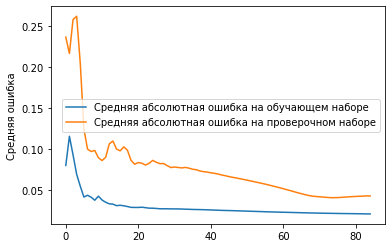

In [78]:
callbaсk = EarlyStopping(monitor='val_mae', patience=10)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(64, return_sequences = "True")) # <None, 3,32>
model.add(Conv1D(64, 3, activation = "linear")) #(None,3,64)
#model.add(Conv1D(64, 1, activation="linear"))
model.add(Flatten())                          # (None, 3*64)
model.add(Dense(3, activation = "linear"))      # (None,3)

model.add(Dense(1, activation = "linear"))

model.compile(loss = "mse", optimizer = "adam", metrics = ['mae'])

history = model.fit(
    dataset_train,
    epochs = epochs,
    validation_data = dataset_val,
    callbacks = [callbaсk, tensorboard_callback])


plt.plot(history.history['mae'][1:], 
         label = 'Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label = 'Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [79]:
# %tensorboard --logdir logs2   

In [80]:
hist_val = history.history['val_mae']
hist_train = history.history['mae']

Epoch 1/100
3/3 [==============================] - 0s 68ms/step - loss: 7.1598e-04 - mae: 0.0213 - val_loss: 0.0025 - val_mae: 0.0438
Epoch 2/100
3/3 [==============================] - 0s 67ms/step - loss: 7.2070e-04 - mae: 0.0213 - val_loss: 0.0025 - val_mae: 0.0434
Epoch 3/100
3/3 [==============================] - 0s 70ms/step - loss: 7.0556e-04 - mae: 0.0211 - val_loss: 0.0026 - val_mae: 0.0443
Epoch 4/100
3/3 [==============================] - 0s 67ms/step - loss: 7.2190e-04 - mae: 0.0213 - val_loss: 0.0025 - val_mae: 0.0433
Epoch 5/100
3/3 [==============================] - 0s 62ms/step - loss: 7.0388e-04 - mae: 0.0210 - val_loss: 0.0027 - val_mae: 0.0451
Epoch 6/100
3/3 [==============================] - 0s 59ms/step - loss: 7.4729e-04 - mae: 0.0217 - val_loss: 0.0024 - val_mae: 0.0429
Epoch 7/100
3/3 [==============================] - 0s 59ms/step - loss: 7.3688e-04 - mae: 0.0214 - val_loss: 0.0029 - val_mae: 0.0464
Epoch 8/100
3/3 [==============================] - 0s 60ms/ste

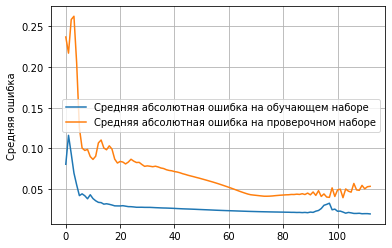

In [81]:
history = model.fit(
    dataset_train,
    epochs = epochs,
    validation_data = dataset_val,
    callbacks = [callbaсk, tensorboard_callback])

hist_val.extend(history.history['val_mae'][:])
hist_train.extend(history.history['mae'][:])

plt.plot(hist_train[1:], 
         label = 'Средняя абсолютная ошибка на обучающем наборе')
plt.plot(hist_val[1:], 
         label = 'Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.grid()
plt.show()

In [82]:
# %tensorboard --logdir logs2

Проверяем результаты:

- строим предсказание
- рисуем прогноз для тестовой части 
- рисуем прогноз по тренировочной части

In [83]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

In [84]:
predVal

array([0.7143854 , 0.62949014, 0.5540124 , 0.4804149 , 0.4373909 ,
       0.42943898, 0.4290444 , 0.44535112, 0.4768707 , 0.515302  ,
       0.57282805, 0.6863701 , 0.853969  , 0.7540269 , 0.6613529 ,
       0.5725536 , 0.5205778 , 0.5108446 , 0.51058334, 0.52379054,
       0.55194896, 0.59789747, 0.6642329 , 0.79344225, 0.98662454,
       0.873002  , 0.7709527 , 0.6698838 , 0.6058956 , 0.5859507 ,
       0.5828982 , 0.59159243, 0.6201573 , 0.6755572 , 0.7646677 ,
       0.92300165, 1.1409516 ], dtype=float32)

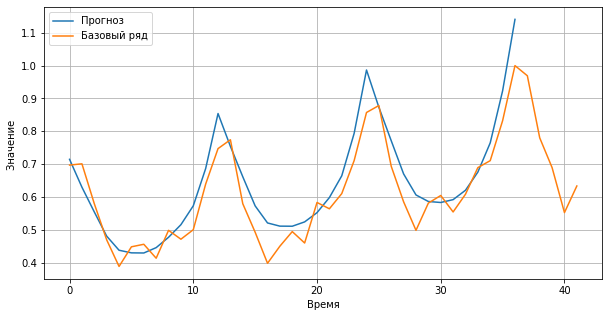

In [85]:
start = 0
step = 50
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[start:start+step], 
         label = 'Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label = 'Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

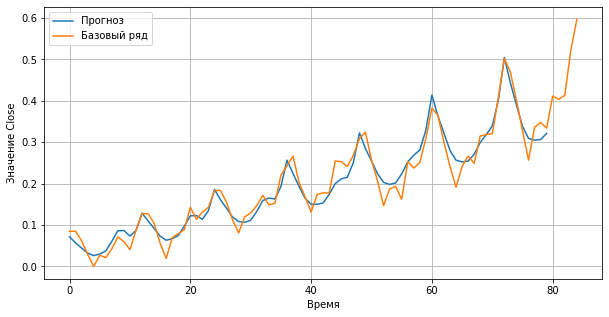

In [86]:
start = 0


plt.figure(figsize = (10,5))
plt.grid('on')
plt.plot(pred[start:train_split], 
         label = 'Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label = 'Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

Проверяем качество модели:
- оценим по лаговой корреляции рядов a, b;
- если наибольшая корреляция с лагом 0, то отлично;
- есди максимум корреляциии на лаге , равном глубине прогноза, то тривиальное предсказание (завтра, как сегодня).


In [87]:
def correlate(a, b):
    ma = a.mean()
    mb = b.mean()
    mab = (a*b).mean()
    sa = a.std()
    sb = b.std()

    val = 0
    if ((sa>0) & (sb>0)):
        val = (mab-ma*mb)/(sa*sb)
    return val

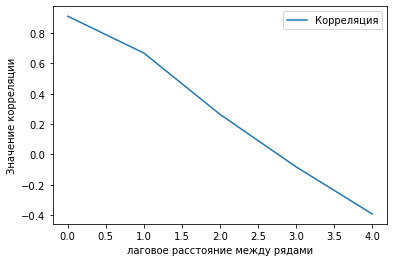

In [88]:
corr = []
start = 0 # начальная точка для проверки корреляций рядов
step = 25 # число точек для проверки корреляций рядов
h=0
yLen = yVal.shape[0]
yValF = yVal[start:start+step].flatten() # ряд истиных значений
yPredVal = predVal[start:start+step] # ряд предсказаний 
# смотрим лаговые корреляции yValF[:-i], yPredVal[i:] для лагов от 0 до 5
for i in range(5):
    corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))

plt.plot(corr, 
         label = 'Корреляция')
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.legend()
plt.show()

In [89]:
corr

[0.9105109127521277,
 0.6679431885177469,
 0.26395308076629753,
 -0.08213665143155126,
 -0.3924630101089734]